<a href="https://colab.research.google.com/github/Aakash326/ML-models/blob/main/101_food_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Wed Jun 11 02:26:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-06-11 02:25:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-11 02:25:57 (69.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import helper_functions

In [ ]:
from helper_functions import make_confusion_matrix, create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

NameError: name 'tfds' is not defined

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
        


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

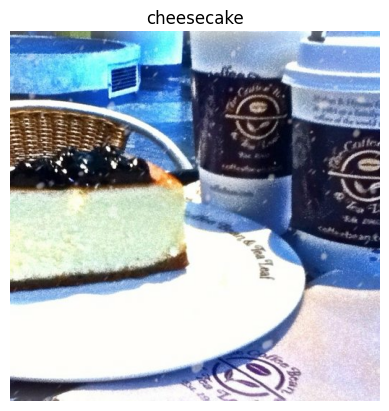

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis("off")

In [ ]:
image.dtype

tf.uint8

In [ ]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[207 220 237]
  [207 220 237]
  [207 220 236]
  ...
  [ 10  11  13]
  [ 11  12  14]
  [ 12  13  15]]

 [[208 219 237]
  [207 220 236]
  [208 220 236]
  ...
  [  9  10  12]
  [ 10  11  13]
  [ 11  12  14]]]...,
Shape: (382, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[207.12596  219.87404  236.77328 ]
  [206.75159  219.39891  235.39891 ]
  [206.33514  216.86098  232.36958 ]
  ...
  [ 10.433058  11.433058  13.433058]
  [  9.974804  10.974804  12.974804]
  [ 11.004499  12.004499  14.004499]]

 [[214.51498  225.25287  240.26627 ]
  [214.24043  223.17825  238.07462 ]
  [213.40561  221.28954  234.25638 ]
  ...
  [ 12.571472  13.571472  15.571472]
  [ 11.928558  12.928558  14.928558]
  [ 11.941964  12.941964  14.941964]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
policy

<DTypePolicy "mixed_float16">

In [ ]:
input_size=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=input_size,name="input_layer")
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(model.name,model.trainable,model.dtype,model.dtype_policy)

functional True float32 <DTypePolicy "mixed_float16">
functional True float32 <DTypePolicy "mixed_float16">
functional True float32 <DTypePolicy "mixed_float16">
functional True float32 <DTypePolicy "mixed_float16">
functional True float32 <DTypePolicy "mixed_float16">


In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [ ]:
model.fit(train_data,epochs=initial_epochs,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=int(0.15*len(train_data)))

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 219s 80ms/step - accuracy: 0.4783 - loss: 2.2858 - val_accuracy: 0.6954 - val_loss: 1.1387
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 221s 69ms/step - accuracy: 0.6687 - loss: 1.2827 - val_accuracy: 0.7162 - val_loss: 1.0333
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 169s 70ms/step - accuracy: 0.7064 - loss: 1.1318 - val_accuracy: 0.7281 - val_loss: 0.9945
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 166s 69ms/step - accuracy: 0.7254 - loss: 1.0423 - val_accuracy: 0.7341 - val_loss: 0.9776
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.7372 - loss: 0.9827 - val_accuracy: 0.7351 - val_loss: 0.9687


In [ ]:
initial_epochs=5

In [ ]:
base_model.trainable=True

for layers in model.layers[:-20]:
  base_model.trainable=False
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

In [ ]:
final_epochs=initial_epochs+10

In [ ]:
model.fit(train_data,epochs=final_epochs,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=int(0.15*len(train_data)),initial_epoch=initial_epochs)

Epoch 6/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 373s 114ms/step - accuracy: 0.6241 - loss: 1.4685 - val_accuracy: 0.7914 - val_loss: 0.7474
Epoch 7/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 256s 107ms/step - accuracy: 0.8036 - loss: 0.7198 - val_accuracy: 0.8121 - val_loss: 0.6763
Epoch 8/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 209s 87ms/step - accuracy: 0.8632 - loss: 0.5009 - val_accuracy: 0.8173 - val_loss: 0.6616
Epoch 9/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 88ms/step - accuracy: 0.9092 - loss: 0.3434 - val_accuracy: 0.8149 - val_loss: 0.6742
Epoch 10/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 110ms/step - accuracy: 0.9378 - loss: 0.2448 - val_accuracy: 0.8175 - val_loss: 0.6753
Epoch 11/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 213s 89ms/step - accuracy: 0.9560 - loss: 0.1778 - val_accuracy: 0.8208 - val_loss: 0.6870
Epoch 12/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 109ms/step - accuracy: 0.9660 - loss: 0.1386 - val_accuracy: 0.8185 - val_loss: 0.7013
Epoch 13/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 109ms/step - a

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8244 - loss: 0.7395


[0.7478699684143066, 0.8216237425804138]

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Screenshot 2025-06-11 at 9.29.02 AM.png to Screenshot 2025-06-11 at 9.29.02 AM.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


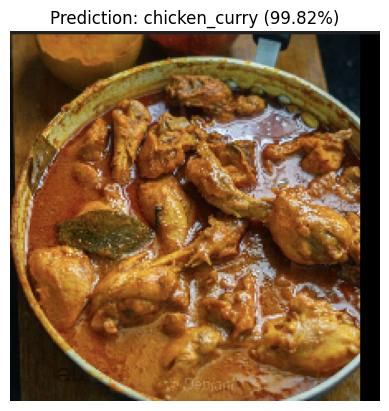

Predicted class: chicken_curry
Confidence: 99.82%


In [ ]:
# Step 1: Load & preprocess the uploaded image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Step 2: Predict
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()
confidence = tf.reduce_max(predictions[0]).numpy()

# ✅ Step 3: Fix class names lookup
class_names = ds_info.features["label"].names  # Use this!

# Step 4: Display result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence*100:.2f}%)")
plt.show()

print(f"Predicted class: {class_names[predicted_class]}")
print(f"Confidence: {confidence*100:.2f}%")


In [ ]:
model.save("food 101.h5")

In [ ]:
# from tensorflow.keras.layers import RandomFlip, RandomZoom, Rescaling

# custom_objects = {
#     "Cast": IdentityCast,
#     "RandomFlip": RandomFlip,
#     "RandomZoom": RandomZoom,
#     "Rescaling": Rescaling
# }

# model = load_model("/content/food 101.h5", custom_objects=custom_objects)


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

# Step 1: Unbatch test data to get images and labels
all_images = []
all_labels = []

for img, label in test_data.unbatch():
    all_images.append(img.numpy())
    all_labels.append(label.numpy())

# Step 2: Pick 9 random samples
random_idxs = random.sample(range(len(all_images)), 9)

# Step 3: Class names
class_names = ds_info.features["label"].names

# Step 4: Create a 3x3 plot
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_idxs):
    img = all_images[idx]
    label = all_labels[idx]

    # Preprocess and predict
    img_processed = tf.expand_dims(img, axis=0)
    pred_probs = model.predict(img_processed, verbose=0)
    pred_class = tf.argmax(pred_probs[0]).numpy()
    confidence = tf.reduce_max(pred_probs[0]).numpy()

    # Choose title color
    color = "green" if pred_class == label else "red"
    title = f"Pred: {class_names[pred_class]} ({confidence*100:.1f}%)\nTrue: {class_names[label]}"

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(title, color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'test_data' is not defined

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step


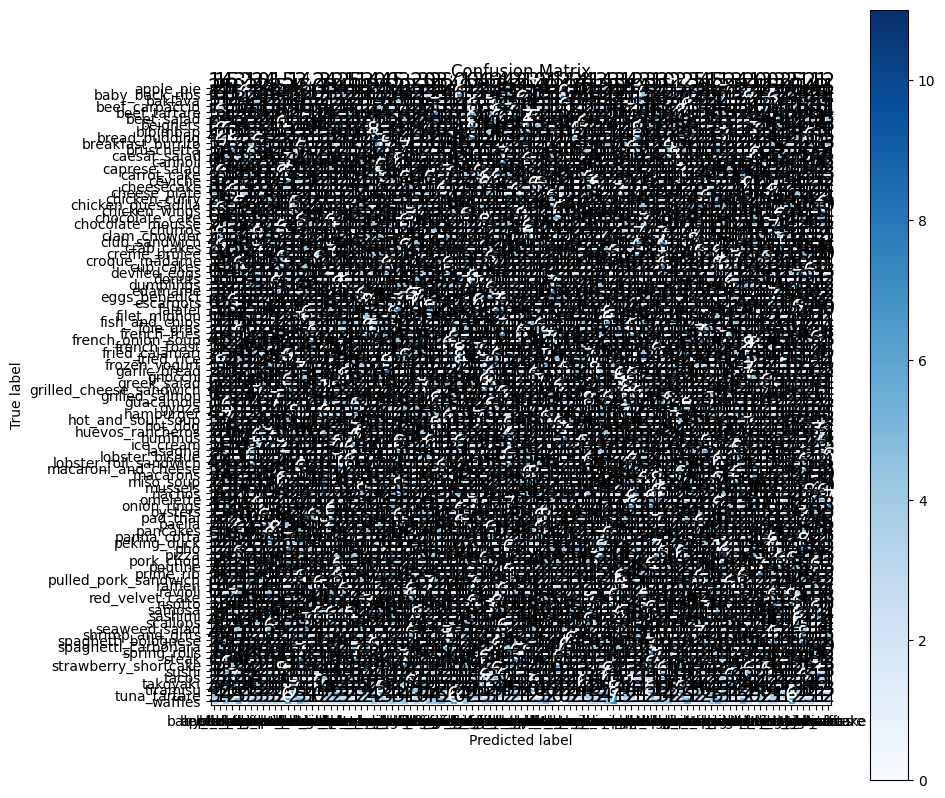

In [ ]:
# Get true labels from test_data
y_true = np.concatenate([y for x, y in test_data], axis=0)


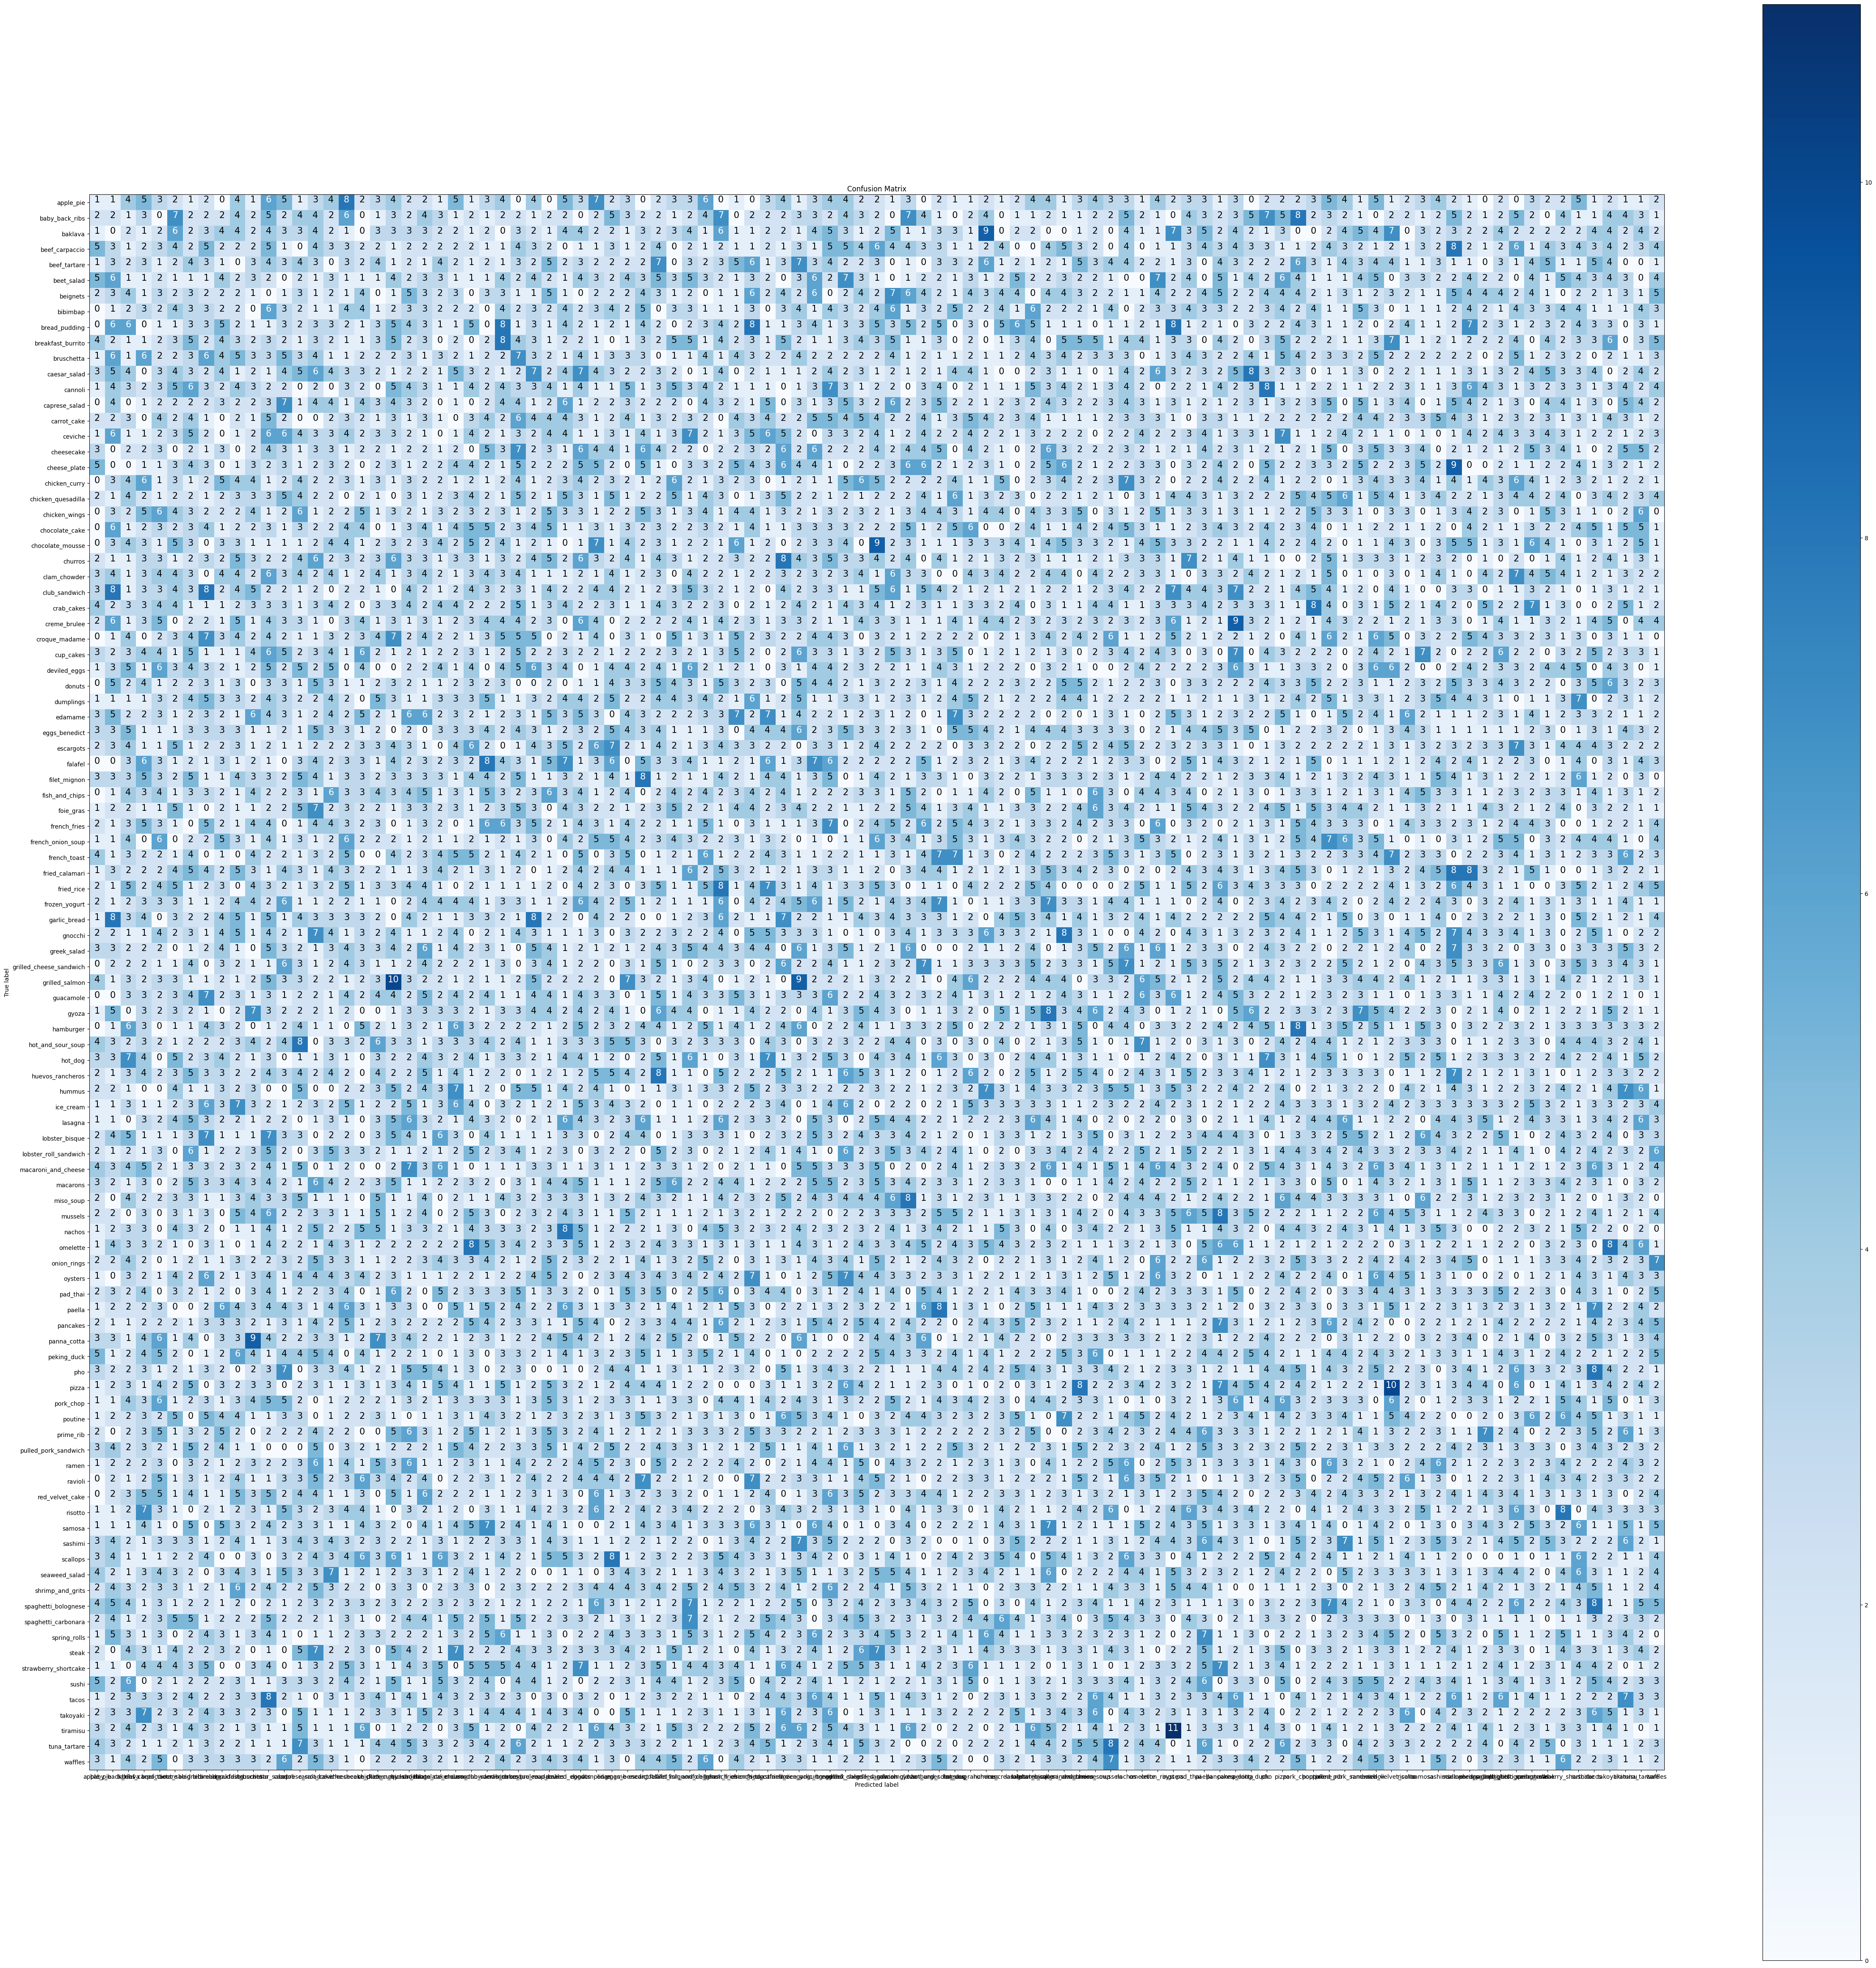

In [ ]:
make_confusion_matrix(y_true, y_pred, class_names, figsize=(60, 60),savefig=True)